(np.float64(-0.5), np.float64(2524.5), np.float64(3299.5), np.float64(-0.5))

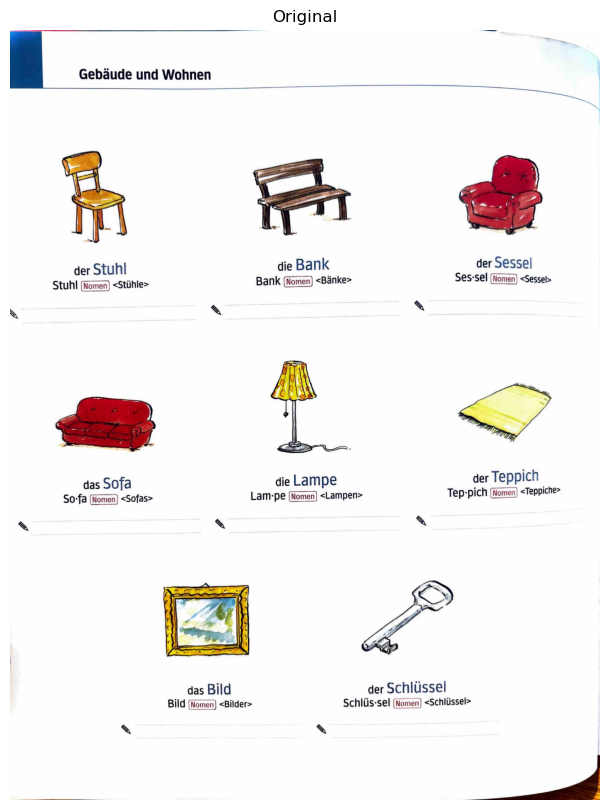

In [5]:
# pip install pillow opencv-python numpy matplotlib

from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# === Bildpfad anpassen ===
SRC = "C:\\Users\\edson\\Downloads\\Flashcard_Projekt\\images\\flashcard_page_21.png"   # <-- HIER dein Bildpfad einsetzen"

# Bild laden
img_pil = Image.open(SRC).convert("RGB")
img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# Anzeige Original
plt.figure(figsize=(8,10))
plt.imshow(img_pil)
plt.title("Original")
plt.axis("off")


(np.float64(-0.5), np.float64(2524.5), np.float64(3299.5), np.float64(-0.5))

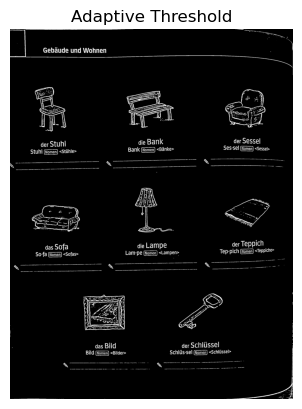

In [6]:
# --- STEP 1: Preprocess ---

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

adaptive = cv2.adaptiveThreshold(
    gray,
    255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV,
    15,
    10
)

plt.imshow(adaptive, cmap="gray")
plt.title("Adaptive Threshold")
plt.axis("off")


(np.float64(-0.5), np.float64(2524.5), np.float64(3299.5), np.float64(-0.5))

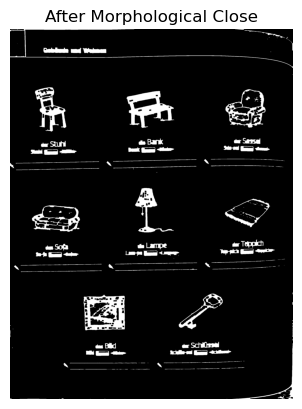

In [7]:
# --- STEP 2: dilation of grayscale image to merge nearby image + text into one shape ---

# Smaller kernel to avoid over-merge
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 10))

closed = cv2.morphologyEx(adaptive, cv2.MORPH_CLOSE, kernel)

plt.imshow(closed, cmap="gray")
plt.title("After Morphological Close")
plt.axis("off")


(np.float64(-0.5), np.float64(2524.5), np.float64(3299.5), np.float64(-0.5))

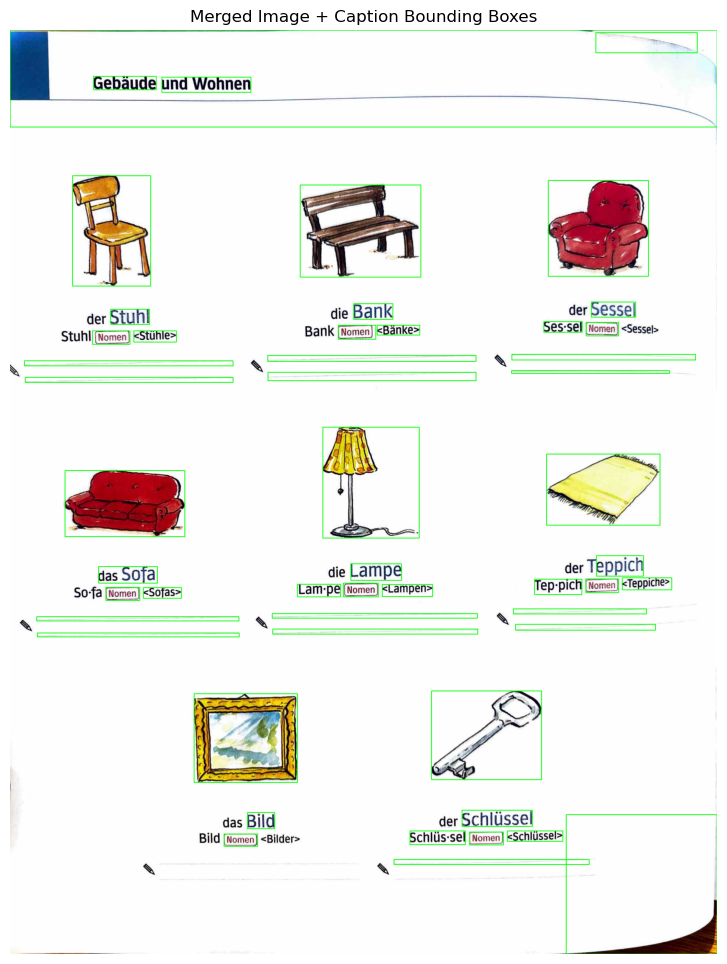

In [8]:
# --- STEP 3: Contour Detection ---

contours, _ = cv2.findContours(
    closed,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

img_draw = img.copy()

# Draw all bounding boxes
cluster_boxes = []

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    
    if w * h > 5000:   # Filter small noise
        cluster_boxes.append((x, y, w, h))
        cv2.rectangle(
            img_draw,
            (x, y),
            (x + w, y + h),
            (0, 255, 0),
            2
        )

plt.figure(figsize=(10,12))
plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
plt.title("Merged Image + Caption Bounding Boxes")
plt.axis("off")


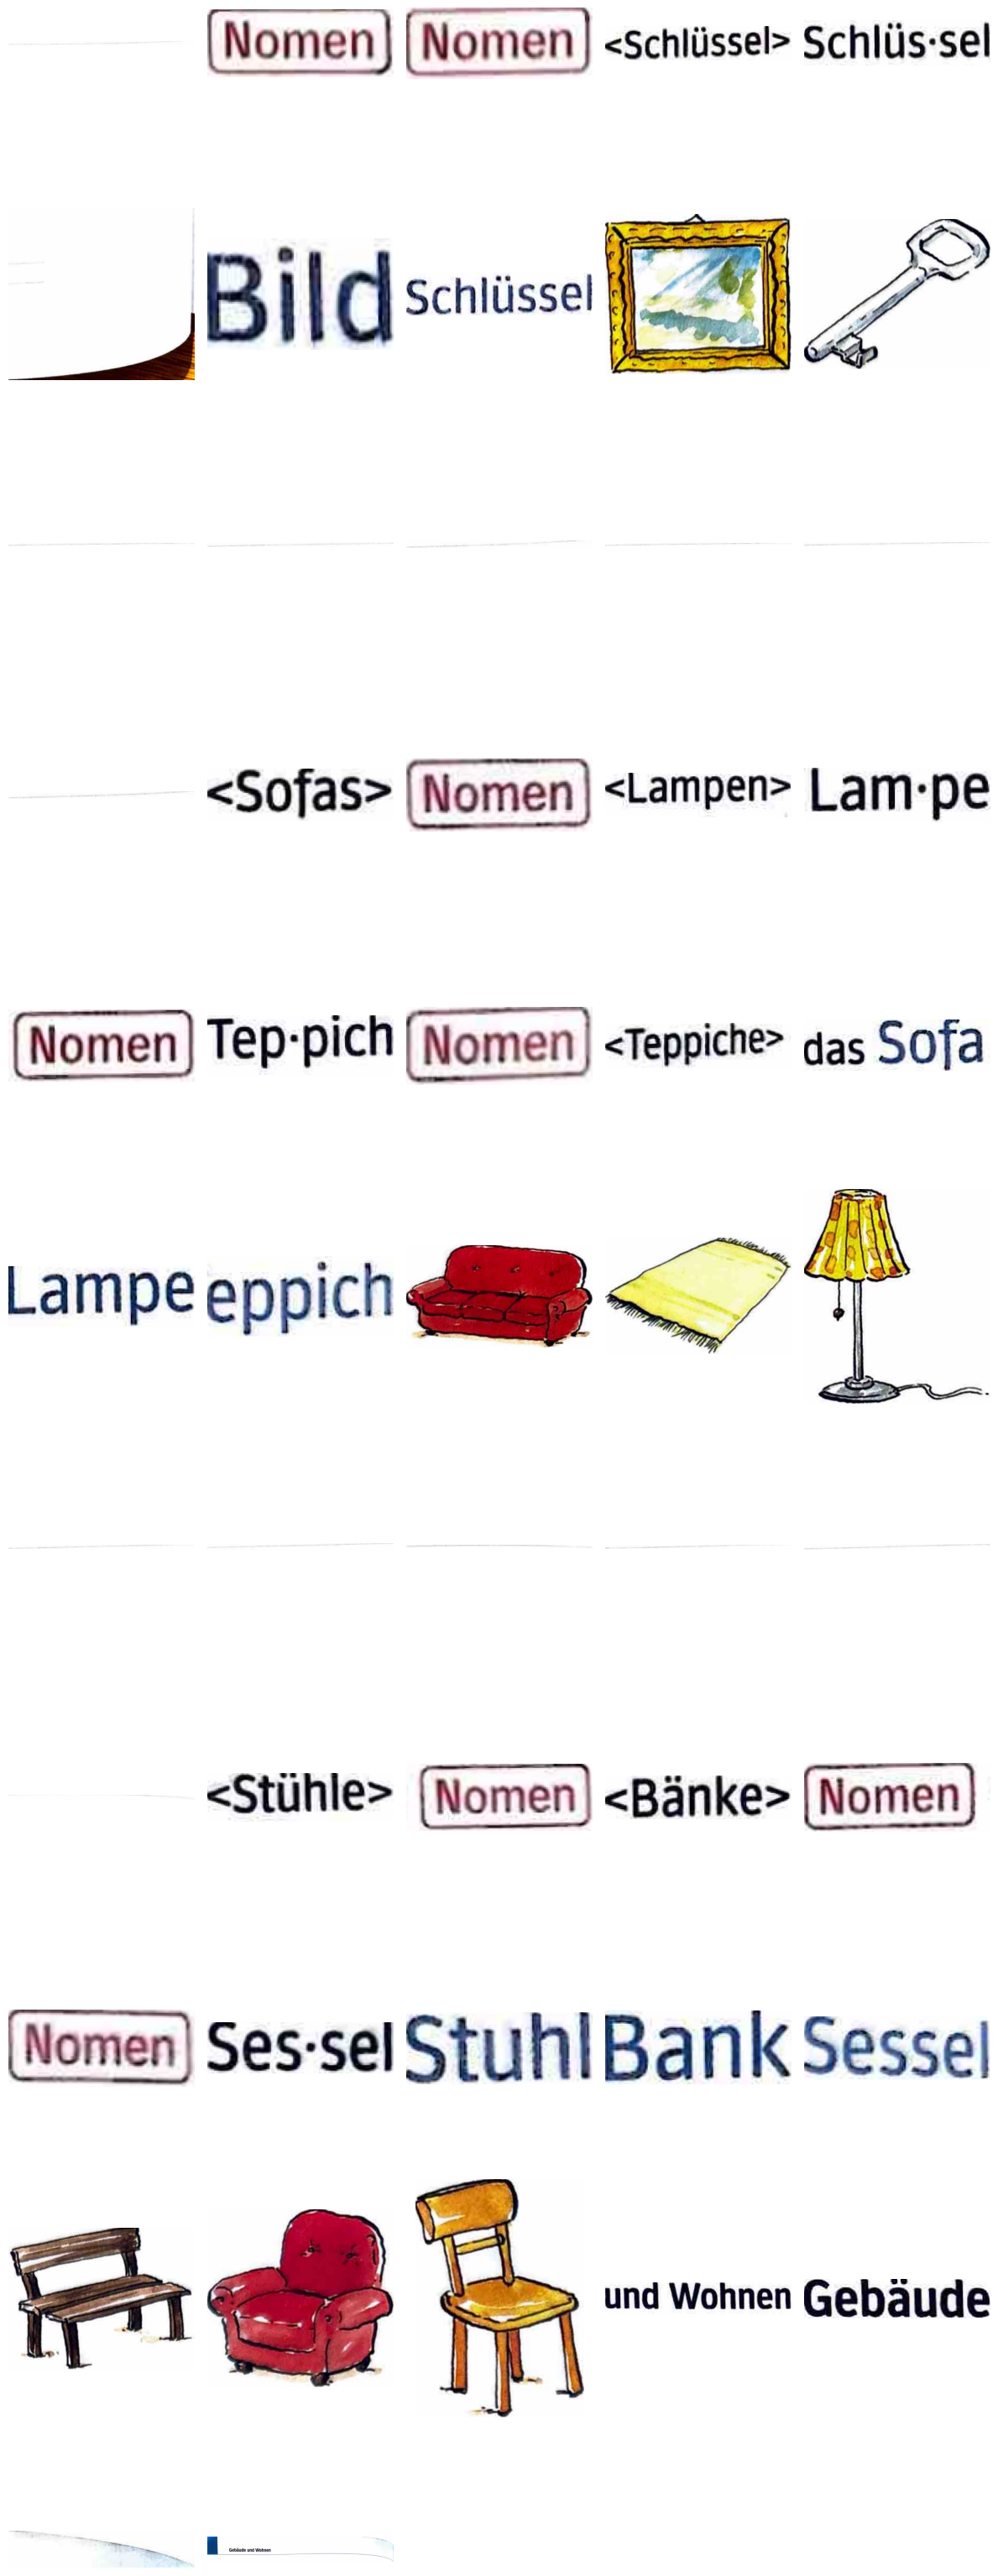

In [10]:
import math

num_segments = len(segments)
cols = 5
rows = math.ceil(num_segments / cols)

plt.figure(figsize=(12, rows * 3))

for i, segment in enumerate(segments):
    plt.subplot(rows, cols, i+1)
    plt.imshow(segment)
    plt.axis("off")

plt.tight_layout()



In [12]:
import cv2
import os

# ===== 1. Ordnerpfade =====
input_folder = "cards"  # Hier liegen deine 177 ausgeschnittenen Karten
output_front = "flashcards/front"
output_back = "flashcards/back"

os.makedirs(output_front, exist_ok=True)
os.makedirs(output_back, exist_ok=True)

# ===== 2. Alle Karten durchgehen =====
for filename in os.listdir(input_folder):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        
        path = os.path.join(input_folder, filename)
        
        # Bild mit OpenCV laden
        img = cv2.imread(path)
        
        if img is None:
            continue
        
        height, width, _ = img.shape
        
        # ===== 3. Karte horizontal teilen =====
        split_point = int(height * 0.7)
        
        front = img[0:split_point, 0:width]          # oberer Teil (Bild)
        back = img[split_point:height, 0:width]      # unterer Teil (Text)
        
        # ===== 4. Speichern =====
        cv2.imwrite(os.path.join(output_front, filename), front)
        cv2.imwrite(os.path.join(output_back, filename), back)

print("Fertig ✅ Flashcards wurden erstellt.")

Fertig ✅ Flashcards wurden erstellt.


In [1]:
import os
from PIL import Image, ImageDraw

# ==============================
# 1️⃣ Einstellungen
# ==============================

# A4 Größe in Pixel (300 DPI)
A4_W, A4_H = 2480, 3508

COLS = 3
ROWS = 3

MARGIN_X = 150
MARGIN_Y = 200

GAP_X = 20
GAP_Y = 20

# Karten-Zielgröße (alle gleich!)
CARD_W = (A4_W - 2*MARGIN_X - (COLS-1)*GAP_X) // COLS
CARD_H = (A4_H - 2*MARGIN_Y - (ROWS-1)*GAP_Y) // ROWS

# Ordner
FRONT_FOLDER = "flashcards/front"
BACK_FOLDER  = "flashcards/back"

OUTPUT_FRONT = "print_pages/front"
OUTPUT_BACK  = "print_pages/back"

os.makedirs(OUTPUT_FRONT, exist_ok=True)
os.makedirs(OUTPUT_BACK, exist_ok=True)


# ==============================
# 2️⃣ Hilfsfunktion: Karte anpassen
# ==============================

def resize_and_pad(img):
    """
    Skaliert Bild proportional
    und fügt weißen Rand hinzu,
    damit jede Karte exakt gleich groß ist.
    """
    img = img.copy()
    img.thumbnail((CARD_W, CARD_H))

    new_img = Image.new("RGB", (CARD_W, CARD_H), "white")

    x = (CARD_W - img.width) // 2
    y = (CARD_H - img.height) // 2

    new_img.paste(img, (x, y))
    return new_img


# ==============================
# 3️⃣ Schneidelinien
# ==============================

def draw_cut_lines(page):
    draw = ImageDraw.Draw(page)

    line_color = (120, 120, 120)
    line_width = 3

    grid_left = MARGIN_X
    grid_top = MARGIN_Y
    grid_right = MARGIN_X + COLS * CARD_W + (COLS - 1) * GAP_X
    grid_bottom = MARGIN_Y + ROWS * CARD_H + (ROWS - 1) * GAP_Y

    # Außenrahmen
    draw.rectangle(
        [grid_left, grid_top, grid_right, grid_bottom],
        outline=line_color,
        width=line_width
    )

    # Vertikale Linien
    for c in range(1, COLS):
        x = MARGIN_X + c * CARD_W + (c - 1) * GAP_X + GAP_X // 2
        draw.line([(x, grid_top), (x, grid_bottom)],
                  fill=line_color, width=line_width)

    # Horizontale Linien
    for r in range(1, ROWS):
        y = MARGIN_Y + r * CARD_H + (r - 1) * GAP_Y + GAP_Y // 2
        draw.line([(grid_left, y), (grid_right, y)],
                  fill=line_color, width=line_width)


# ==============================
# 4️⃣ Seiten generieren
# ==============================

def make_pages(input_folder, output_folder):

    files = sorted([
        f for f in os.listdir(input_folder)
        if f.endswith(".png") or f.endswith(".jpg")
    ])

    images = [resize_and_pad(Image.open(os.path.join(input_folder, f)))
              for f in files]

    page_number = 1

    for i in range(0, len(images), 9):

        page = Image.new("RGB", (A4_W, A4_H), "white")

        for idx, img in enumerate(images[i:i+9]):

            row = idx // COLS
            col = idx % COLS

            x = MARGIN_X + col * (CARD_W + GAP_X)
            y = MARGIN_Y + row * (CARD_H + GAP_Y)

            page.paste(img, (x, y))

        # ✂ Schneidelinien zeichnen
        draw_cut_lines(page)

        page.save(os.path.join(output_folder, f"page_{page_number}.png"))
        page_number += 1


# ==============================
# 5️⃣ Front + Back erzeugen
# ==============================

make_pages(FRONT_FOLDER, OUTPUT_FRONT)
make_pages(BACK_FOLDER, OUTPUT_BACK)

print("Fertig ✅ Druckseiten wurden erstellt.")

Fertig ✅ Druckseiten wurden erstellt.


In [7]:
import os
import math
from PIL import Image, ImageDraw, ImageOps
import re

# =========================
# 0) EINSTELLUNGEN
# =========================
FRONT_DIR = r"flashcards/front"
BACK_DIR  = r"flashcards/back"
OUT_DIR   = r"print_pages"
os.makedirs(OUT_DIR, exist_ok=True)

# A4 bei 300 DPI
DPI = 300
A4_W, A4_H = 2480, 3508  # px @300dpi

MARGIN = 140             # Rand in px
GAP = 0                  # Abstand zwischen Karten (0 = direkt an Linie)
DRAW_GRID = True
GRID_WIDTH = 2           # Linienbreite

# Karte in Zelle: "contain" = ganzes Bild sichtbar, ggf. weiße Ränder
# "cover"   = füllt Zelle komplett, ggf. wird etwas abgeschnitten (zoom/crop)
FIT_MODE = "contain"     # "contain" oder "cover"

# Falls die Rückseite bei dir IMMER auf dem Kopf rauskommt:
ROTATE_BACK_180 = False  # True/False


# =========================
# 1) HELFER: SORTIERUNG
# =========================
def natural_key(s):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r"(\d+)", s)]

def list_images(folder):
    files = [f for f in os.listdir(folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    files.sort(key=natural_key)
    return files


# =========================
# 2) HELFER: Bild in Zelle setzen
# =========================
def place_into_cell(img: Image.Image, cell_w: int, cell_h: int, mode="contain") -> Image.Image:
    # img ist PIL Image
    if mode == "contain":
        # passt komplett rein, evtl. Ränder
        img2 = ImageOps.contain(img, (cell_w, cell_h))
        canvas = Image.new("RGB", (cell_w, cell_h), "white")
        x = (cell_w - img2.size[0]) // 2
        y = (cell_h - img2.size[1]) // 2
        canvas.paste(img2, (x, y))
        return canvas

    elif mode == "cover":
        # füllt Zelle komplett, evtl. crop
        img2 = ImageOps.fit(img, (cell_w, cell_h), method=Image.Resampling.LANCZOS, centering=(0.5, 0.5))
        return img2

    else:
        raise ValueError("mode must be 'contain' or 'cover'")


# =========================
# 3) 3x3 Seite bauen
# =========================
def build_grid_page(image_paths, out_path, grid_map=None, rotate_all_180=False):
    """
    image_paths: Liste mit bis zu 9 Pfaden (in 'normaler' Reihenfolge)
    grid_map: optional mapping von index->index für Platzierung
              z.B. Spiegelung der Spalten etc.
    rotate_all_180: dreht ganze Seite 180° (für manche Duplex-Setups)
    """
    page = Image.new("RGB", (A4_W, A4_H), "white")
    draw = ImageDraw.Draw(page)

    usable_w = A4_W - 2*MARGIN
    usable_h = A4_H - 2*MARGIN

    cell_w = (usable_w - 2*GAP) // 3
    cell_h = (usable_h - 2*GAP) // 3

    # grid_map: falls None -> normale Reihenfolge
    if grid_map is None:
        grid_map = list(range(9))

    # Zeichne Zellen
    for pos in range(9):
        r = pos // 3
        c = pos % 3

        x0 = MARGIN + c*(cell_w + GAP)
        y0 = MARGIN + r*(cell_h + GAP)
        x1 = x0 + cell_w
        y1 = y0 + cell_h

        # Welche Quelle kommt an diese Position?
        src_index = grid_map[pos]
        if src_index < len(image_paths):
            img = Image.open(image_paths[src_index]).convert("RGB")
            tile = place_into_cell(img, cell_w, cell_h, mode=FIT_MODE)
            page.paste(tile, (x0, y0))

        if DRAW_GRID:
            draw.rectangle([x0, y0, x1, y1], outline="gray", width=GRID_WIDTH)

    if rotate_all_180:
        page = page.rotate(180, expand=False)

    page.save(out_path, dpi=(DPI, DPI))
    return out_path


# =========================
# 4) Mapping für Rückseite (Alignment!)
# =========================
# Positionen 0..8:
# 0 1 2
# 3 4 5
# 6 7 8

# Für "an langer Kante wenden" (book flip):
# Rückseite muss LINKS/RECHTS gespiegelt werden, damit nach dem Umdrehen die Karte passt.
MAP_MIRROR_COLS = [
    2,1,0,
    5,4,3,
    8,7,6
]

# Für "an kurzer Kante wenden" (top flip):
# Rückseite muss OBEN/UNTEN gespiegelt werden
MAP_MIRROR_ROWS = [
    6,7,8,
    3,4,5,
    0,1,2
]


# =========================
# 5) ALLE SEITEN ERZEUGEN + PDF BAUEN
# =========================
front_files = list_images(FRONT_DIR)
back_files  = list_images(BACK_DIR)

# Sicherstellen: gleiche Anzahl & gleiche Reihenfolge (wichtig!)
n = min(len(front_files), len(back_files))
front_files = front_files[:n]
back_files  = back_files[:n]

front_paths = [os.path.join(FRONT_DIR, f) for f in front_files]
back_paths  = [os.path.join(BACK_DIR,  f) for f in back_files]

# In 9er Blöcke
chunks = math.ceil(n / 9)

long_edge_pages = []
short_edge_pages = []

for i in range(chunks):
    start = i*9
    end   = min((i+1)*9, n)

    front_chunk = front_paths[start:end]
    back_chunk  = back_paths[start:end]

    # Frontseite (normal)
    out_front = os.path.join(OUT_DIR, f"sheet_{i+1:03d}_front.jpg")
    build_grid_page(front_chunk, out_front, grid_map=list(range(9)), rotate_all_180=False)

    # Rückseite – Variante A: lange Kante (Spalten spiegeln)
    out_back_long = os.path.join(OUT_DIR, f"sheet_{i+1:03d}_back_LONG.jpg")
    build_grid_page(
        back_chunk,
        out_back_long,
        grid_map=MAP_MIRROR_COLS,
        rotate_all_180=ROTATE_BACK_180
    )

    # Rückseite – Variante B: kurze Kante (Reihen spiegeln)
    out_back_short = os.path.join(OUT_DIR, f"sheet_{i+1:03d}_back_SHORT.jpg")
    build_grid_page(
        back_chunk,
        out_back_short,
        grid_map=MAP_MIRROR_ROWS,
        rotate_all_180=ROTATE_BACK_180
    )

    # Seiten sammeln (Front dann Back)
    long_edge_pages.append(Image.open(out_front).convert("RGB"))
    long_edge_pages.append(Image.open(out_back_long).convert("RGB"))

    short_edge_pages.append(Image.open(out_front).convert("RGB"))
    short_edge_pages.append(Image.open(out_back_short).convert("RGB"))

# PDFs speichern (multipage)
pdf_long  = os.path.join(OUT_DIR, "print_long_edge.pdf")
pdf_short = os.path.join(OUT_DIR, "print_short_edge.pdf")

if long_edge_pages:
    long_edge_pages[0].save(pdf_long, save_all=True, append_images=long_edge_pages[1:])
if short_edge_pages:
    short_edge_pages[0].save(pdf_short, save_all=True, append_images=short_edge_pages[1:])

print("Fertig ✅")
print("PDF (lange Kante): ", pdf_long)
print("PDF (kurze Kante): ", pdf_short)

Fertig ✅
PDF (lange Kante):  print_pages\print_long_edge.pdf
PDF (kurze Kante):  print_pages\print_short_edge.pdf
